In [1]:
import numpy as np
import pandas as pd
import os
import time

os.chdir('../..')
import AstroPack as AP
os.chdir('./hyperparameter_tuning/feh')

from matplotlib import rc
rc('text', usetex=True)

from sklearn.model_selection import train_test_split

%matplotlib inline

# Getting the data

In [7]:
# Create a list of the columns that will be used
ColumnList = ['TILE_ID', 'NUMBER', 'combined_feh'] + AP.Filters['JPLUS'] + AP.Filters['WISE']

# Import the full dataframe with stars that have both JPLUS, WISE and LAMOST data
os.chdir('../../data')
StarsRaw = pd.read_csv('STEPEs Input Data.csv', usecols=ColumnList)
os.chdir('../hyperparameter_tuning/feh')

# Drop any row with missing values from the dataframe
StarsRaw = StarsRaw.dropna()

# Convert it into a dataframe with magnitudes and colors, indexed by the TILE ID and NUMBER of the star
StarsRaw, Stars = AP.AssembleWorkingDF(StarsRaw, addWISE=True, addGAIA = False, addGALEX=False, Colors=True, Combinations=False)

In [8]:
feh = StarsRaw['combined_feh']

In [9]:
Stars

,uJAVA,J0378,J0395,J0410,J0430,gSDSS,J0515,rSDSS,J0660,iSDSS,...,(zSDSS - W1),(zSDSS - W2),(zSDSS - W3),(zSDSS - W4),(W1 - W2),(W1 - W3),(W1 - W4),(W2 - W3),(W2 - W4),(W3 - W4)
ID NUMBER,,,,,,,,,,,,,,,,,,,,,
"74970, 27876",18.510300,18.677572,18.294348,17.746620,17.765726,17.364323,17.211205,16.937682,16.895009,16.813219,...,1.427427,1.397427,3.777427,7.645427,-0.030000,2.350000,6.218000,2.380000,6.248000,3.868000
"74970, 28786",18.681479,18.260496,18.225178,17.770169,17.802049,17.491011,17.346547,17.151969,17.139990,17.101623,...,1.308205,0.917206,4.230206,7.853205,-0.390999,2.922001,6.545000,3.313000,6.935999,3.622999
"74970, 22231",18.442708,18.168748,18.165806,17.697921,17.638708,17.342219,17.271138,17.061790,17.088039,16.994983,...,1.268077,1.166077,4.333077,7.652077,-0.102000,3.065000,6.384000,3.167000,6.486000,3.319000
"74970, 25105",18.334427,18.029652,18.009411,17.662632,17.488697,17.311178,17.211997,17.036282,17.053552,16.970657,...,1.161751,0.985752,4.227751,7.675752,-0.175999,3.066000,6.514001,3.241999,6.690000,3.448001
"74970, 25815",16.499126,16.210025,16.135031,15.683990,15.634652,15.421811,15.299540,15.126609,15.124688,15.053313,...,1.255060,1.169061,2.227060,5.616060,-0.085999,0.972000,4.361000,1.058000,4.447000,3.389000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"63487, 15250",17.036599,16.638777,16.665518,16.121685,16.088707,15.767068,15.659821,15.401905,15.388118,15.297113,...,1.414089,1.353089,2.510089,6.425089,-0.061000,1.096000,5.011000,1.157000,5.072000,3.915000
"63487, 4099",14.855529,14.536378,14.400999,14.044807,13.980539,13.806083,13.727394,13.612124,13.624944,13.586199,...,1.195371,1.189371,1.152371,4.891371,-0.006000,-0.043000,3.696000,-0.037000,3.702001,3.739000
"63487, 7893",15.701442,15.564832,15.385651,14.716053,14.613263,14.208155,14.081196,13.762161,13.723630,13.655106,...,1.408605,1.361605,1.700605,5.043604,-0.047000,0.292000,3.634999,0.339000,3.681999,3.342999


In [10]:
feh

ID NUMBER
74970, 27876   -0.398
74970, 28786   -0.664
74970, 22231   -0.151
74970, 25105   -0.304
74970, 25815   -0.539
                ...  
63487, 15250   -0.407
63487, 4099    -0.448
63487, 7893     0.175
63487, 2312     0.263
63487, 2409    -0.294
Name: combined_feh, Length: 186232, dtype: float64

# Random Forest CV - FeH

In [11]:
XDevelop, XTest, yDevelop, yTest = train_test_split(Stars, feh, test_size=0.25, random_state=42)

In [12]:
import itertools

n_features = [10, 15, 45, 60, 136]
n_trees = [50, 100]
min_samples_leaf = [10]
max_features = [0.1, 0.25, 0.5, 0.75, 'auto']
criterion = ["mse"]

HPCombinations = [item for item in itertools.product(n_features, n_trees, min_samples_leaf, max_features, criterion)]

In [ ]:
for HPCombination in HPCombinations:
    Metrics = AP.rf_evaluator(HPCombination, XDevelop, yDevelop, n_splits = 5, n_repeats = 3, verbose = 0)
    pd.DataFrame(data=(HPCombination + Metrics)).T.to_csv('rf_FeH_tuning.csv', mode='a', index = False, header = False)

# Graphical Analysis

In [2]:
hp_tuning_rf = pd.read_csv('rf_FeH_tuning.csv')

x_axis = {'max_features': ['0.25', '0.5', '0.75', 'auto']}
y_axis = {'n_features': [136, 60, 45, 15]}

In [3]:
t_50_l_1_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 50, 'min_samples_leaf': 1}, x_axis, y_axis, 'R2')
t_100_l_1_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 100, 'min_samples_leaf': 1}, x_axis, y_axis, 'R2')
t_50_l_10_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 50, 'min_samples_leaf': 10}, x_axis, y_axis, 'R2')
t_100_l_10_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 100, 'min_samples_leaf': 10}, x_axis, y_axis, 'R2')

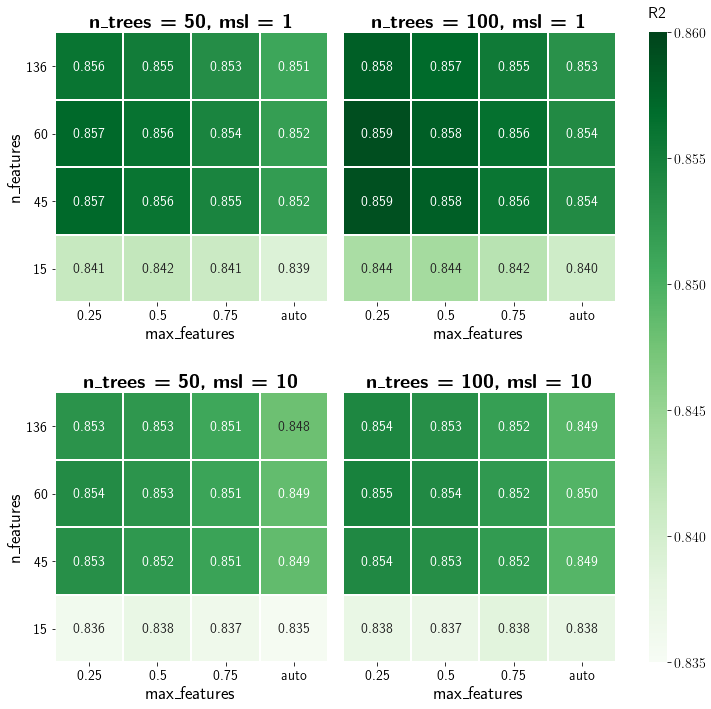

In [5]:
figure = AP.plot_heatmaps(t_50_l_1_matrix, r'\textbf{n\_trees = 50, msl = 1}',  
                          t_50_l_10_matrix, r'\textbf{n\_trees = 50, msl = 10}',
                          t_100_l_1_matrix, r'\textbf{n\_trees = 100, msl = 1}',
                          t_100_l_10_matrix, r'\textbf{n\_trees = 100, msl = 10}', 
                          value_format = '.3f', cmap = 'Greens', v_min = 0.835, v_max = 0.86, 
                          colorbar_label='R2', colorbar_ticks = 6)

figure.savefig('rf_FeH_R2_heatmap.jpg', dpi = 250)

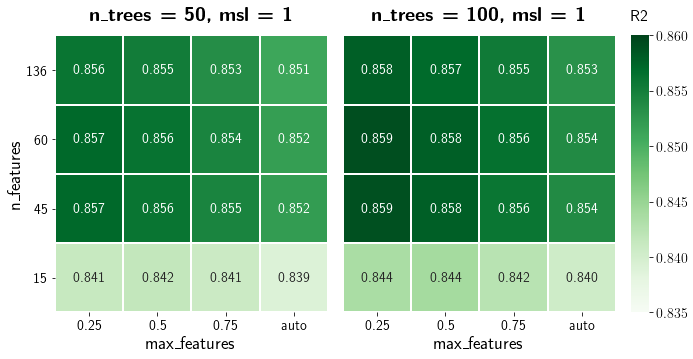

In [6]:
figure = AP.plot_heatmaps_single_line(t_50_l_1_matrix, r'\textbf{n\_trees = 50, msl = 1}',
                                      t_100_l_1_matrix, r'\textbf{n\_trees = 100, msl = 1}',
                                      value_format = '.3f', cmap = 'Greens', v_min = 0.835, v_max = 0.86, 
                                      colorbar_label='R2', colorbar_ticks = 6)

figure.savefig('rf_FeH_R2_heatmap (msl = 1).jpg', dpi = 250)

In [7]:
t_50_l_1_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 50, 'min_samples_leaf': 1}, x_axis, y_axis, 'Time').astype(int)
t_100_l_1_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 100, 'min_samples_leaf': 1}, x_axis, y_axis, 'Time').astype(int)
t_50_l_10_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 50, 'min_samples_leaf': 10}, x_axis, y_axis, 'Time').astype(int)
t_100_l_10_matrix = AP.create_heatmap_matrix(hp_tuning_rf, {'n_trees': 100, 'min_samples_leaf': 10}, x_axis, y_axis, 'Time').astype(int)

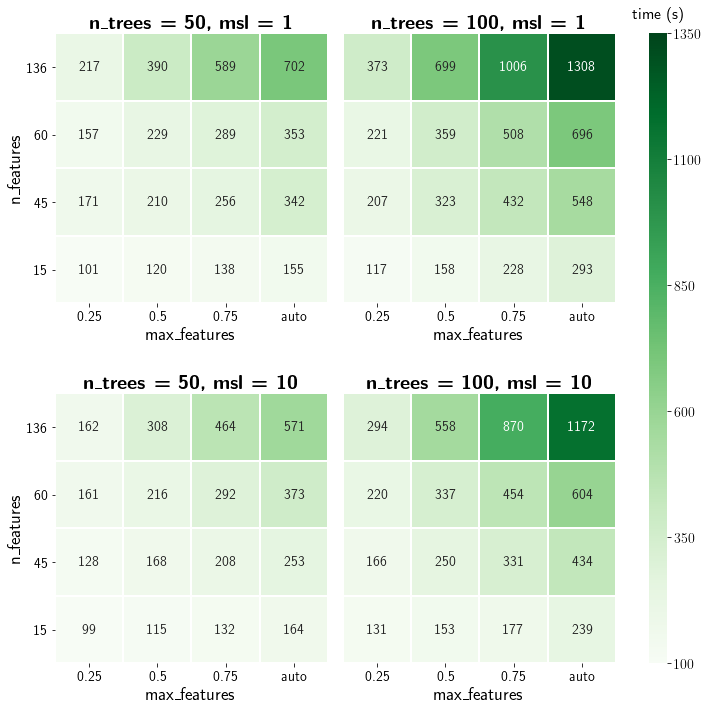

In [9]:
figure = AP.plot_heatmaps(t_50_l_1_matrix, r'\textbf{n\_trees = 50, msl = 1}',  
                          t_50_l_10_matrix, r'\textbf{n\_trees = 50, msl = 10}',
                          t_100_l_1_matrix, r'\textbf{n\_trees = 100, msl = 1}',
                          t_100_l_10_matrix, r'\textbf{n\_trees = 100, msl = 10}', 
                          value_format = 'd', cmap = 'Greens', v_min = 100, v_max = 1350,
                          colorbar_label='time (s)', colorbar_ticks = 6)

figure.savefig('rf_FeH_time_heatmap.jpg', dpi = 250)

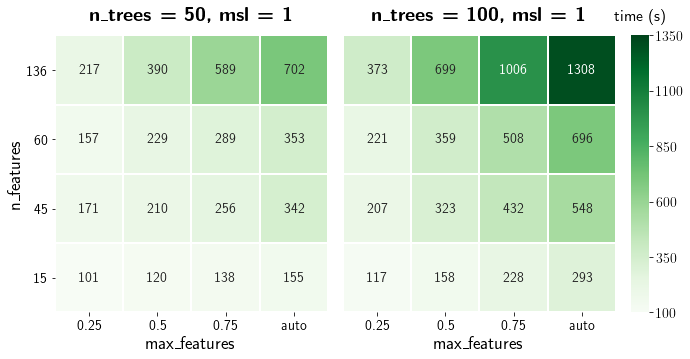

In [10]:
figure = AP.plot_heatmaps_single_line(t_50_l_1_matrix, r'\textbf{n\_trees = 50, msl = 1}',
                                      t_100_l_1_matrix, r'\textbf{n\_trees = 100, msl = 1}',
                                      value_format = 'd', cmap = 'Greens', v_min = 100, v_max = 1350,
                                      colorbar_label='time (s)', colorbar_ticks = 6)

figure.savefig('rf_FeH_time_heatmap (msl = 1).jpg', dpi = 250)